In [11]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

In [13]:
K = 40
r = 0.05
sigma = 0.15
T = 1
S_range = [0, 160]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)  ## Analytical sol

In [14]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

# get_diff_data(10)[0]    # X values (stock price and time)
# get_diff_data(10)[1]    # y values (0s)

In [15]:
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

# get_ivp_data(10)

In [16]:
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2

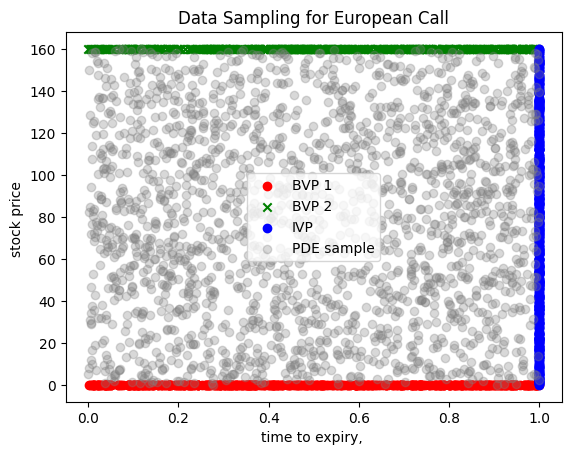

In [17]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(500)
ivp_x1,ivp_y1 = get_ivp_data(500)
diff_x1,diff_y1 = get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "PDE sample", color = "grey", alpha = 0.3)
plt.xlabel("time to expiry, ")
plt.ylabel("stock price ")
plt.title("Data Sampling for European Call")
plt.legend()

## Simulation with PINN

In [18]:
class european_call(nn.Module):
    "Defines a Physics informed network"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        activation2 = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation1])
        self.fch = nn.Sequential(*[nn.Sequential(*[
                            nn.BatchNorm1d(N_HIDDEN),
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation1]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [9]:
model = european_call(2,1,100,8)
optimizer = torch.optim.Adam(model.parameters(),lr=7e-5)
print (f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

Model parameters : 82.80K


In [21]:
N_sample = 500
physics_lr = 1000

loss_history={
    "total_loss":[],"loss1":[],"loss2":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

for i in range(10000):
    optimizer.zero_grad()

    # Get IVP data
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float().to(DEVICE)
    ivp_y_tensor = torch.from_numpy(ivp_y).float().to(DEVICE)
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # Get BVP data
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float().to(DEVICE)
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float().to(DEVICE)
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float().to(DEVICE)
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float().to(DEVICE)
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Aggregate the "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(4*N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_().to(DEVICE)
    y1 = torch.from_numpy(y1).float().to(DEVICE)
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss1"].append(loss1.item())
    loss_history["loss2"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss.backward()
    optimizer.step()


    # Plot the result as training progresses
    if (i + 1) % 500 == 0:
        print(f"Epoch {i+1}, Loss: {loss.item():.6f}")

Epoch 500, Loss: 15603.125000
Epoch 1000, Loss: 11158.362305
Epoch 1500, Loss: 9326.254883
Epoch 2000, Loss: 8689.823242
Epoch 2500, Loss: 8327.205078
Epoch 3000, Loss: 8209.606445
Epoch 3500, Loss: 9072.782227
Epoch 4000, Loss: 9553.990234
Epoch 4500, Loss: 7948.082031
Epoch 5000, Loss: 7756.223145
Epoch 5500, Loss: 8545.047852
Epoch 6000, Loss: 8104.560059
Epoch 6500, Loss: 7935.728027
Epoch 7000, Loss: 7982.491211
Epoch 7500, Loss: 7834.576172
Epoch 8000, Loss: 8293.128906
Epoch 8500, Loss: 7861.169922
Epoch 9000, Loss: 7773.304199
Epoch 9500, Loss: 8699.019531
Epoch 10000, Loss: 8154.266113


Text(0, 0.5, 'Log loss')

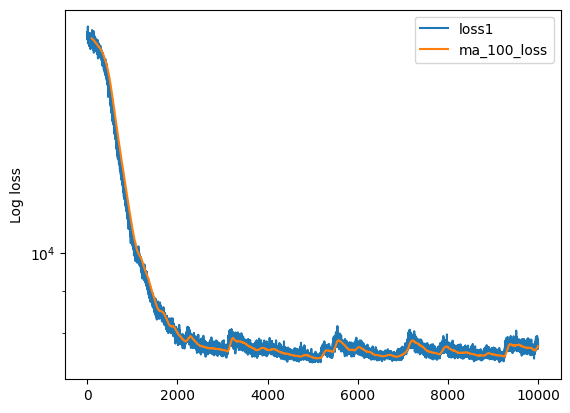

In [38]:
loss_df = pd.DataFrame.from_dict(loss_history)
# loss_df["loss"] = loss_history
loss_df["ma_100_loss"] = loss_df["loss1"].rolling(100).mean()
ax = loss_df.plot(y='loss1', logy=True)
loss_df.plot(y='ma_100_loss', ax=ax)
ax.set_ylabel("Log loss")

In [39]:
loss_df.head()

,total_loss,loss1,loss2,loss_bvp1,loss_bvp2,loss_ivp,ma_100_loss
0,19225.933594,18514.949219,710.984741,0.080513,14670.634766,3844.233887,NaN
1,19053.355469,18472.958984,580.397461,0.079179,14666.413086,3806.466553,NaN
2,18710.216797,18179.382812,530.833679,0.075174,14645.671875,3533.635498,NaN
3,18842.183594,18253.455078,588.728577,0.071056,14657.453125,3595.930176,NaN
4,18769.261719,18206.173828,563.088257,0.066422,14672.808594,3533.298584,NaN


In [40]:
loss_df.tail(100).mean()

total_loss     9011.539893
loss1          7717.025747
loss2          1294.514173
loss_bvp1      3452.331323
loss_bvp2      3891.405393
loss_ivp        373.288995
ma_100_loss    7653.873458
dtype: float64

Text(0.5, 1.0, 'Total Training loss')

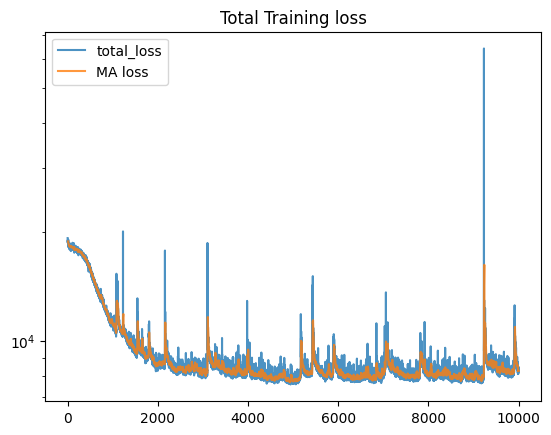

In [41]:
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Total Training loss")

Text(0.5, 1.0, 'Training Curve for Moving Average of losses')

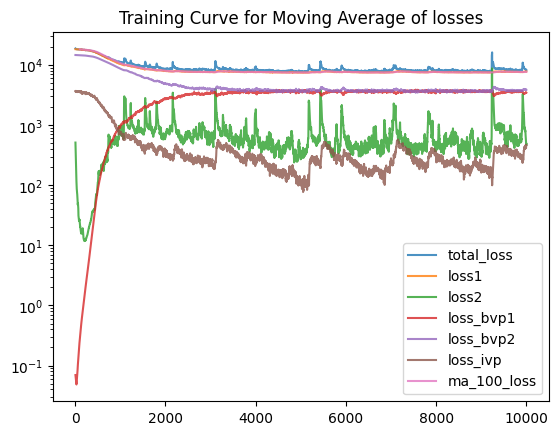

In [42]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8)
plt.title("Training Curve for Moving Average of losses")

<Axes: >

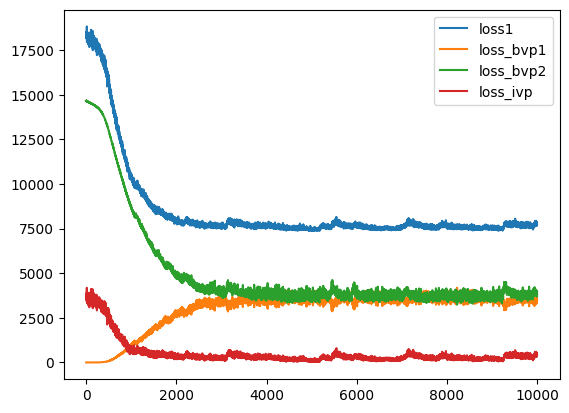

In [43]:
loss_df[["loss1","loss_bvp1","loss_bvp2","loss_ivp"]].plot()

## Evaluation

In [44]:
def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Time to maturity (assumed in years)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Normal cumulative distribution function (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculate the option price
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C

In [45]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150], device='cuda:0')

In [46]:
s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)

s_flat = s_grid.flatten()
t_flat = t_grid.flatten()

# Create a 2D tensor from the flattened arrays
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)

y_analytical_test = eur_call_analytical_price(X_test[:,1],X_test[:,0],torch.tensor([K]), sigma = sigma)
X_test.shape,y_analytical_test.shape

(torch.Size([2500, 2]), torch.Size([2500]))

In [47]:
with torch.no_grad():
  y_pinn_test = model(X_test)

Text(0.5, 1.0, 'European Call Option pricing')

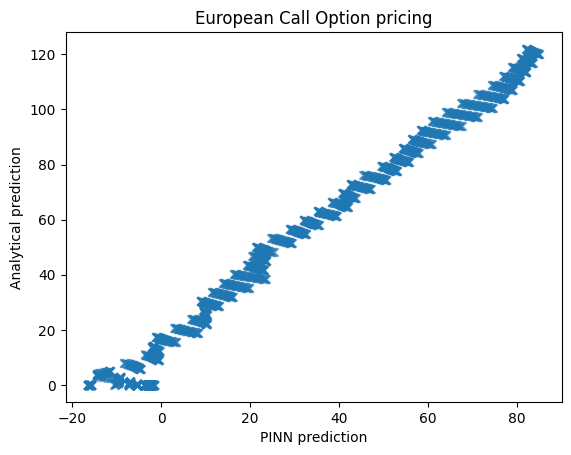

In [51]:
plt.scatter(x= y_pinn_test.cpu().detach().numpy(), y = y_analytical_test.cpu().detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("PINN prediction")
plt.ylabel("Analytical prediction")
plt.title("European Call Option pricing")

In [53]:
y_pinn_test.cpu().detach().numpy().shape

(2500, 1)

In [54]:
np.corrcoef(y_pinn_test.cpu().detach().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.cpu().detach().numpy())

array([[1.       , 0.9920951],
       [0.9920951, 1.       ]])

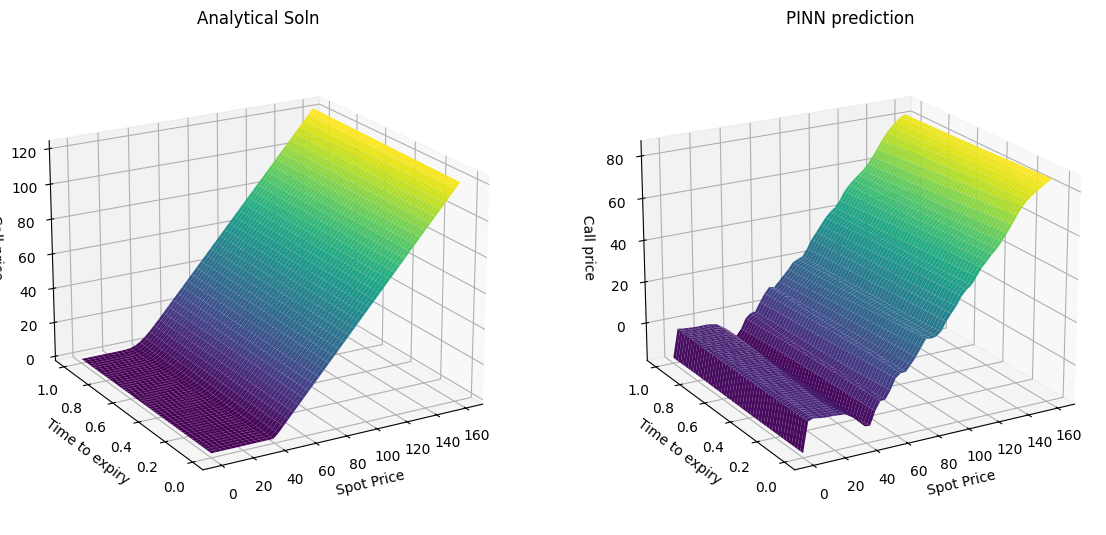

In [56]:
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.cpu().detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Analytical Soln")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.cpu().detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("PINN prediction")
ax.set_xlabel("Spot Price")
ax.set_ylabel("Time to expiry")
ax.set_zlabel("Call price")
ax.view_init(elev=20, azim=-120)

torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analytical vs PINN price for t = 0.75')

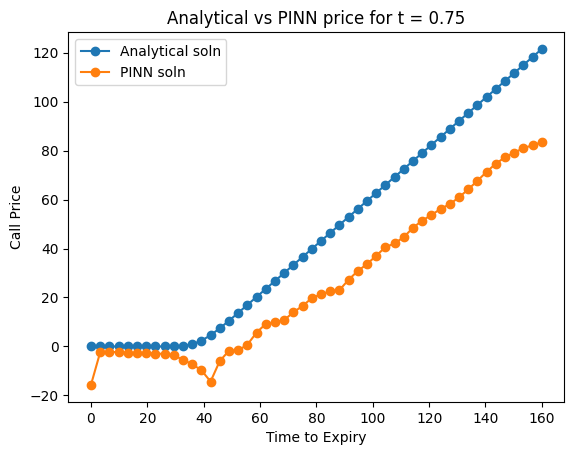

In [58]:
s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.75]*s1.shape[0])

# Create a 2D tensor from the flattened arrays
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.cpu().detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.cpu().detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analytical vs PINN price for t = 0.75")